https://fehiepsi.github.io/rethinking-numpyro/04-geocentric-models.html

In [1]:
!pip install -q numpyro arviz

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 2.34.4 requires packaging<22.0dev,>=14.3, but you have packaging 24.1 which is incompatible.
jupyterlab 4.2.4 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.2 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
osmnx 1.9.4 requires shapely<2.1,>=2.0, but you have shapely 1.8.5.post1 which is incompatible.
pointpats 2.5.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spaghetti 1.7.6 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.1 requires shapely>=2.0.

In [2]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import random, vmap

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

In [3]:
pos = jnp.sum(dist.Uniform(-1, 1).sample(random.PRNGKey(0), (1000, 16)), -1)

In [4]:
jnp.prod(1 + dist.Uniform(0, 0.1).sample(random.PRNGKey(0), (12,)))

Array(1.7294353, dtype=float32)

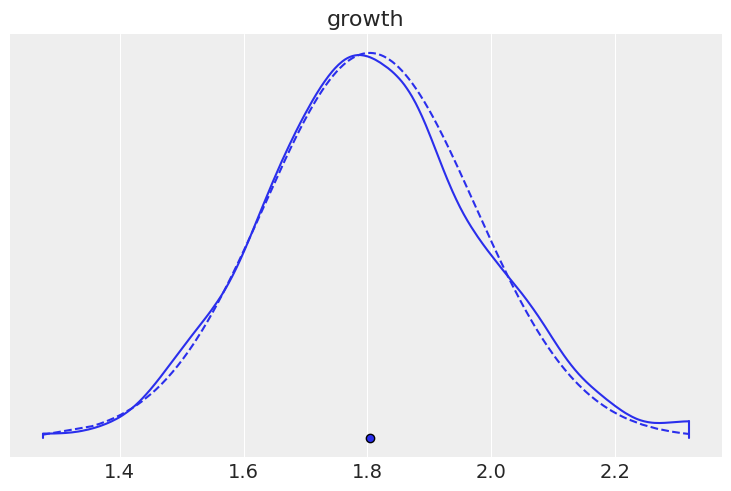

In [5]:
growth = jnp.prod(1 + dist.Uniform(0, 0.1).sample(random.PRNGKey(0), (1000, 12)), -1)
az.plot_density({"growth": growth}, hdi_prob=1)
x = jnp.sort(growth)
plt.plot(x, jnp.exp(dist.Normal(jnp.mean(x), jnp.std(x)).log_prob(x)), "--")
plt.show()